In [1]:
import torch
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import dataloader
from torchvision.datasets import MNIST
import torch.nn.functional as F


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

/home/mahavir/code/python_projects/ml_dl_projects/2_hand_digit_recognization/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
root_data_path = "../../data"
train_dataset = MNIST(root_data_path,train=True,download=True)
test_dataset = MNIST(root_data_path,train=False,download=True)

In [4]:
img,index = train_dataset[0]

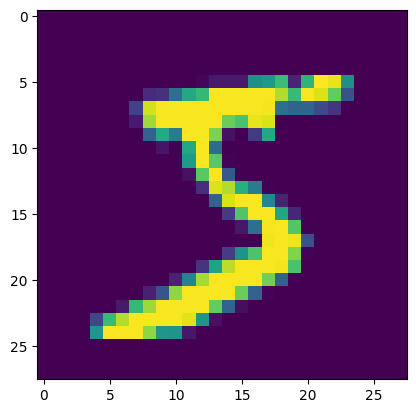

In [5]:

plt.imshow(img)

In [6]:
index

5

In [7]:
np.shape(img)

(28, 28)

In [8]:
len(train_dataset)

60000

In [9]:
len(test_dataset)

10000

In [10]:
def process_data(data):
    img_list = []
    index_list = []
    for img,index in data:

        img_list.append(torch.tensor(np.array(img) / 255,dtype=torch.float32))
        index_list.append(torch.tensor(torch.tensor(index),dtype=torch.int32))
    
    return {'images':img_list,'indexs':index_list}

In [11]:
processed_train_data = process_data(train_dataset)


/tmp/ipykernel_42262/65033573.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_list.append(torch.tensor(torch.tensor(index),dtype=torch.int32))


In [12]:
processed_test_data = process_data(test_dataset)


/tmp/ipykernel_42262/65033573.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index_list.append(torch.tensor(torch.tensor(index),dtype=torch.int32))


In [13]:
processed_test_data['images'][0].shape

torch.Size([28, 28])

In [14]:
processed_train_data.keys()

dict_keys(['images', 'indexs'])

In [15]:
from torch.utils.data import TensorDataset,dataset

train_images = torch.stack(processed_train_data['images']).unsqueeze(1)

In [16]:
train_index = torch.tensor(processed_train_data['indexs'],dtype=torch.long)
train_index

tensor([5, 0, 4,  ..., 5, 6, 8])

In [17]:
train_dataset = TensorDataset(train_images,train_index)
train_dataset

In [18]:
test_images = torch.stack(processed_test_data['images']).unsqueeze(1)
test_indexs = torch.tensor(processed_test_data['indexs'],dtype=torch.long)

test_dataset = TensorDataset(test_images,test_indexs)
test_dataset

In [19]:
train_dataloader = dataloader.DataLoader(train_dataset,64,shuffle=True)
test_dataloader = dataloader.DataLoader(test_dataset,64,shuffle=True)

In [28]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn1 = nn.Conv2d(1,32,3,1)
        self.cnn2 = nn.Conv2d(32,64,3,1)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.50)

        self.fc1 = nn.Linear(64 * 5 * 5,128)
        self.fc2 = nn.Linear(128,10)

    # def forward(self,x):
    #     x = nn.MaxPool2d(nn.ReLU(self.cnn1(x)),2)
    #     x = nn.MaxPool2d(nn.ReLU(self.cnn2(x)),2)
    #     x = self.dropout1(x)
    #     x = nn.Flatten(x,1)
    #     x = self.fc1(x)
    #     x = nn.ReLU(x)
    #     x = self.dropout2(x)
    #     x = self.fc2(x)

    #     output = nn.LogSoftmax(x,1)
    #     return output

    def forward(self,x):
        x = F.relu(self.cnn1(x))
        x = F.max_pool2d(x,2)
        x = F.relu(self.cnn2(x))
        x = F.max_pool2d(x,2)
        x = self.dropout1(x)
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        output = F.log_softmax(x)
        return output

In [29]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.NLLLoss()

In [30]:
def train(epoch):
    model.train()

    for batch_idx,(data,target) in enumerate(train_dataloader):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_dataloader.dataset)}]  Loss: {loss.item():.6f}")


In [31]:
# 6. Test loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get index of max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_dataloader)
    accuracy = 100. * correct / len(test_dataloader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.2f}%)\n")

# 7. Run training and testing
for epoch in range(1, 3):  # run for 2 epochs for demo, you can increase
    train(epoch)
    test()

/tmp/ipykernel_42262/4026002235.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 1 [0/60000]  Loss: 2.312211
Train Epoch: 1 [6400/60000]  Loss: 0.491811
Train Epoch: 1 [12800/60000]  Loss: 0.189616
Train Epoch: 1 [19200/60000]  Loss: 0.210555
Train Epoch: 1 [25600/60000]  Loss: 0.215373
Train Epoch: 1 [32000/60000]  Loss: 0.240989
Train Epoch: 1 [38400/60000]  Loss: 0.259831
Train Epoch: 1 [44800/60000]  Loss: 0.144214
Train Epoch: 1 [51200/60000]  Loss: 0.200945
Train Epoch: 1 [57600/60000]  Loss: 0.288720

Test set: Average loss: 0.0621, Accuracy: 9810/10000 (98.10%)

Train Epoch: 2 [0/60000]  Loss: 0.059606
Train Epoch: 2 [6400/60000]  Loss: 0.075983
Train Epoch: 2 [12800/60000]  Loss: 0.334308
Train Epoch: 2 [19200/60000]  Loss: 0.089214
Train Epoch: 2 [25600/60000]  Loss: 0.064862
Train Epoch: 2 [32000/60000]  Loss: 0.107897
Train Epoch: 2 [38400/60000]  Loss: 0.270623
Train Epoch: 2 [44800/60000]  Loss: 0.115529
Train Epoch: 2 [51200/60000]  Loss: 0.036223
Train Epoch: 2 [57600/60000]  Loss: 0.066057

Test set: Average loss: 0.0475, Accuracy: 983

predecting 1 image manually

In [53]:
image,label = test_dataset[765]

In [54]:
image = image.unsqueeze(0)
image

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [55]:
output = model(image)
output

/tmp/ipykernel_42262/4026002235.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


tensor([[-1.5316e+01, -1.5316e+01, -1.5316e+01, -1.5316e+01, -8.9407e-06,
         -1.4837e+01, -1.5316e+01, -1.4753e+01, -1.4355e+01, -1.1929e+01]],
       grad_fn=<LogSoftmaxBackward0>)

In [56]:
max(output[0])

tensor(-8.9407e-06, grad_fn=<UnbindBackward0>)

In [57]:
pred = output.argmax(dim=1, keepdim=True)
pred

tensor([[4]])

In [58]:
label

tensor(4)